# ID5 Daten einlesen

Um die Messdaten aus dem iD5 in python einlesen zu können, kann die Funktion **read_ID5_data** verwendet werden. Dafür muss in die Funktion nur der Dateipfad angegeben werden

In [2]:
# Import of used libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import DataFrame
import numpy as np
import math
import regex as re
from scipy.optimize import curve_fit
from asyncore import read

# Formula for the regression
def lin (a, x, b):
    return a * x + b

def set_ticksStyle(x_size=30, y_size=30, x_dir='in', y_dir='in'):
    sns.set_style('ticks', {'xtick.major.size': x_size, 'ytick.major.size': y_size, 'xtick.direction': x_dir, 'ytick.direction': y_dir})

### Function to read ID5 file

In [3]:
# Function to read ID5 ... Data
def read_ID5_data(filepath):
    # create a list with all possible well identifiers. 
    # needed later with the Melt function in Pandas
    letter=["A","B","C","D","E","F","G","H"]
    plate = []
    for l in letter:
        for i in range(1,13):
            plate.append(l+str(i))

    # initialisation of all variables
    meta = []
    data = []
    cols = []
    data_dict = {}
    iterator = 1

    # opening the CSV file
    with open(filepath, 'r', encoding='UTF-8') as file:
        # skip first line
        next(file)
        # read file line by line
        lines = file.readlines()
        # go through lines line by line
        for line in lines:
            # skip blank lines
            if not line.isspace():
                # delete new lines
                line = line.strip('\n')
                # skip the Group-part of the document
                if line.startswith('Group'):
                    break
                if line.startswith("Plate"):
                    # Here the metadata is loaded in for the very first line only. line.split() creates a list with all elements between the ";"
                    meta = line.split("\t")
                    # Everything that is empty in the list is deleted
                    meta = list(filter(None, meta))
                elif line.startswith("Wavelength"):
                    cols = line.split('\t')
                # If the line starts with ~End, the previously read stuff is processed
                elif line.startswith("~End"):
                    # create a dataframe with the read column names from an empty list
                    df = pd.DataFrame(data, columns=cols)
                    # delete first row of dataframe (it contains the column names)
                    df = df.iloc[1: , :]
                    # replace empty columns with NaNs
                    df = df.replace("", np.nan)
                    # delete columns containing NaNs
                    df = df.dropna(axis=1, how="any")
                    # Now the table is melted. That means the well numbers are assigned to the wavelength and the temperature. With list(set(plate).intersection(df.columns)) only the well numbers are filtered which really exist.
                    df = df.melt(id_vars = df.columns[:2],value_vars= list(set(plate).intersection(df.columns)))
                    # renaming the columns
                    df.columns = ["wavelength", "temperature", "well", "value"]
                    # change values in columns wavelength, temperature and value to numeric values to be on the safe side
                    df[["wavelength", "temperature", "value"]] = df[["wavelength", "temperature", "value"]].apply(pd.to_numeric)
                    #  sort dataframe; first by ascending wavelength, then by ascending well
                    df_sort = df.sort_values(['wavelength', 'well'], ignore_index = True)
                    # Creating an empty list for corrected measured values, which are calculated following
                    liste = []
                    # go through wavelengths
                    for wavelength in pd.unique(df_sort['wavelength']):
                        # create sub-dataframe for every wavelengths
                        sub_df = df_sort[df_sort['wavelength'] == wavelength]
                        # go through wells A-H in this sub-dataframe
                        for well in pd.unique(sub_df['well'].str[0]):
                            # create another data frame containing only those wells of the same type (e.g. A)
                            char_df = sub_df[sub_df['well'].str[0] == well[0]]
                            # identification of value to be subtracted from the other values
                            val1 = char_df['value'].iloc[0]
                            # corrected values: val1 ist substracted from all values
                            corr_vals = char_df['value'] - val1
                            # append corrected values to empty list
                            liste.append(corr_vals)

                    # List with corrected values is appended to the sorted dataframe as an additional column
                    df_sort['corrected_value'] = pd.concat(liste)
                    # dataframe is assigned to the dictionary by an iterator. The first measurement taken is then measurement 0 and so on.
                    data_dict[f"Measurement{iterator}"] = df_sort
                    data_dict[f"Metadata{iterator}"] = meta
                    # Reinitialization for next loop
                    meta = list()
                    data = list()
                    cols = list()
                    iterator += 1
                    df.empty
                    pass
                # If there is no Plate or ~End or nothing, data is written to a list that will later be built into the DataFrame.
                else:
                    if len(line.split('\t')) > 0:
                        hlp = line.split('\t')
                        data.append(hlp)
    return data_dict  

### Using the function "read_ID5_data"

In the following code block, the usage of the function **read_ID5_data** is demonstrated. The file path must be specified. If the file to be read is located in the same folder as the Jupyter Notebook, then the file name is sufficient.

In [4]:
# reading the file
data_ID5 = read_ID5_data("voll.txt")
# Measurement output
print(data_ID5.keys())

dict_keys(['Measurement1', 'Metadata1', 'Measurement2', 'Metadata2'])


The following Codeblock shows how to access the individual measurements:

In [5]:
M1 = data_ID5["Measurement1"]
M2 = data_ID5["Measurement2"]

### Function to get specific well from specific measurement

In [6]:
def get_well(dataframe: DataFrame, measurement: str, wellnumber: str):
    try: 
        meas_x = dataframe[measurement]
    except KeyError:
        print("Measurement does not exist.")
    else:
        meas_well = meas_x[(meas_x.loc[:,'well'] == wellnumber)]
        if meas_well.empty:
            print("Wellnumber does not exist.")
        else:
            return meas_well

### Using the function "get_well"

In [13]:
M1_A1 = get_well(dataframe = data_ID5, measurement = "Measurement1", wellnumber = "A1")
M1_A2 = get_well(dataframe = data_ID5, measurement = "Measurement1", wellnumber = "A2")
M1_B2 = get_well(dataframe = data_ID5, measurement = "Measurement1", wellnumber = "B2")
M1_C2 = get_well(dataframe = data_ID5, measurement = "Measurement1", wellnumber = "C2")

# or shorter (but keep order in mind):

M1_D2_short = get_well(data_ID5, "Measurement1", "D2")

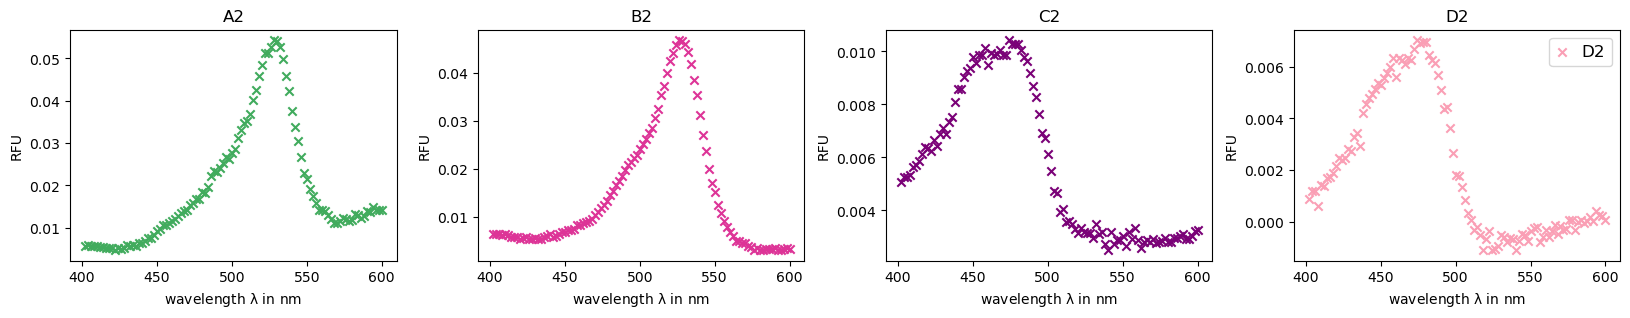

In [17]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 3), sharex=False, sharey=False, squeeze=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

ax[0,0].scatter(M1_A2["wavelength"], M1_A2["corrected_value"], marker="x", color="#41ab5d")
ax[0,0].set_title("A2")

ax[0,1].scatter(M1_B2["wavelength"], M1_B2["value"], marker="x", color="#dd3497")
ax[0,1].set_title("B2")

ax[0,2].scatter(M1_C2["wavelength"], M1_C2["value"], marker="x", color="#7a0177")
ax[0,2].set_title("C2")

ax[0,3].scatter(M1_D2_short["wavelength"], M1_D2_short["value"], marker="x", color="#fa9fb5", label='D2')
ax[0,3].set_title("D2")
ax[0,3].legend(frameon=True, handlelength=0.75, fontsize='large', loc='upper right', bbox_to_anchor=(1.00, 1.00))

# set labels
plt.setp(ax[:, :], xlabel='wavelength $\mathregular{\lambda}$ in nm')
plt.setp(ax[:, :], ylabel='RFU')

plt.savefig(f"2022-07-07_Cy3_em.png", dpi=300, bbox_inches="tight")
plt.show()

### ToDo: Function to get multiple wells from one specific measurement